In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns


In [ ]:
file_path = "vehicles.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "austinreese/craigslist-carstrucks-data",
    file_path
)


<ipython-input-2-0838bf365f19>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
# Step 1: Drop unuseful columns
df_cleaned = df.drop(columns=['lat', 'long', 'posting_date', 'id', 'url', 'region_url', 'description', 'VIN', 'image_url', 'county'])

# Step 2: Convert 'price' to numeric and drop rows with invalid prices
df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')
df_cleaned.dropna(subset=['price'], inplace=True)

# Step 3: Filter price range and year due to extreme outliers
df_cleaned = df_cleaned[(df_cleaned['price'] > 1000) & (df_cleaned['price'] <= 40000)]
df_cleaned = df_cleaned[(df_cleaned['year'] >= 1997) & (df_cleaned['year'] <= 2020)]

# Step 4: Create 'age' column (2020 - year), then drop 'year'
df_cleaned['age'] = 2020 - df_cleaned['year']
df_cleaned = df_cleaned.drop(columns='year')

# Step 5: Handle missing values
df_cleaned.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#fill empty rows with a value
# Fill numeric columns with the mean
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

# Fill categorical columns with 'alternatives'
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].fillna('alternatives')

#needed since there was too many categories and it cause ram crashing
def group_rare_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)  # Get relative frequencies
    common = value_counts[value_counts >= threshold].index  # Categories with freq >= threshold
    return series.apply(lambda x: x if x in common else 'uncommon')  # Replace rare categories with 'uncommon'

#list of categorical columns
cols_to_group = ['transmission', 'type', 'condition', 'title_status','region',
                         'manufacturer', 'model', 'cylinders', 'fuel', 'drive', 'size', 'paint_color', 'state']

# Apply the function to each column in the list
for col in cols_to_group:
    df_cleaned[col] = group_rare_categories(df_cleaned[col], threshold=0.10)

# Step 6: One-hot encode categorical variables
df_cleaned = pd.get_dummies(df_cleaned, columns=['transmission', 'type', 'condition', 'title_status','region',
                         'manufacturer', 'model', 'cylinders', 'fuel', 'drive', 'size', 'paint_color', 'state'], drop_first=True)

# Step 7: Split features and target
X = df_cleaned.drop(columns='price')
y = df_cleaned['price']

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Scale numeric features
scaler = StandardScaler()
X_train[['odometer']] = scaler.fit_transform(X_train[['odometer']])
X_test[['odometer']] = scaler.transform(X_test[['odometer']])
X_train[['age']] = scaler.fit_transform(X_train[['age']])
X_test[['age']] = scaler.transform(X_test[['age']])


# Step 10: Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 11: Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 12: Feature importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("\nTop Features by Permutation Importance:")
print(importance_df.head(10))

# Step 13: Select important features for the second model
# Based on the permutation importance results
top_features = importance_df.head(10)['feature'].tolist()

# Filter X_train and X_test to only include the important features
X_train_important = X_train[top_features]
X_test_important = X_test[top_features]

# Step 14: Train second model using only important features
model_important = LinearRegression()
model_important.fit(X_train_important, y_train)

# Step 15: Evaluate the second model (using only important features)
y_pred_important = model_important.predict(X_test_important)
mae_important = mean_absolute_error(y_test, y_pred_important)
mse_important = mean_squared_error(y_test, y_pred_important)
rmse_important = np.sqrt(mse_important)
r2_important = r2_score(y_test, y_pred_important)

print(f"\nMAE (Important Features): {mae_important:.2f}")
print(f"MSE (Important Features): {mse_important:.2f}")
print(f"RMSE (Important Features): {rmse_important:.2f}")
print(f"R² Score (Important Features): {r2_important:.2f}")


<ipython-input-5-77efa5610129>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['age'] = 2020 - df_cleaned['year']


MAE: 4989.09
MSE: 41540987.94
RMSE: 6445.23
R² Score: 0.63

Top Features by Permutation Importance:
                   feature  importance_mean  importance_std
1                      age         0.678696        0.003195
19               drive_fwd         0.136442        0.001034
14   cylinders_8 cylinders         0.089978        0.001358
13   cylinders_6 cylinders         0.046378        0.000724
18      drive_alternatives         0.039388        0.000557
2       transmission_other         0.034793        0.000637
17           fuel_uncommon         0.034674        0.000688
15  cylinders_alternatives         0.021134        0.000474
6            type_uncommon         0.020968        0.000772
0                 odometer         0.013881        0.000254

MAE (Important Features): 5081.83
MSE (Important Features): 43011844.18
RMSE (Important Features): 6558.34
R² Score (Important Features): 0.62


<ipython-input-4-ac8f25e0fb67>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_mean', y='feature', data=top_features, palette='viridis')


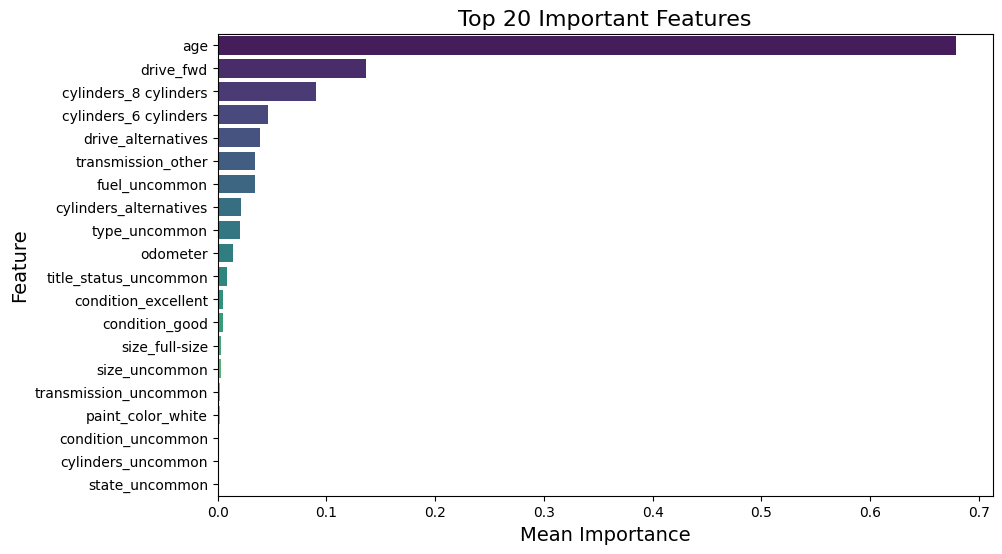

In [ ]:
# top features to display
n_top_features = 20

# Prepare the feature importance dataframe
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Select top N features
top_features = importance_df.head(n_top_features)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='importance_mean', y='feature', data=top_features, palette='viridis')

# title and labels
plt.title(f'Top {n_top_features} Important Features', fontsize=16)
plt.xlabel('Mean Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

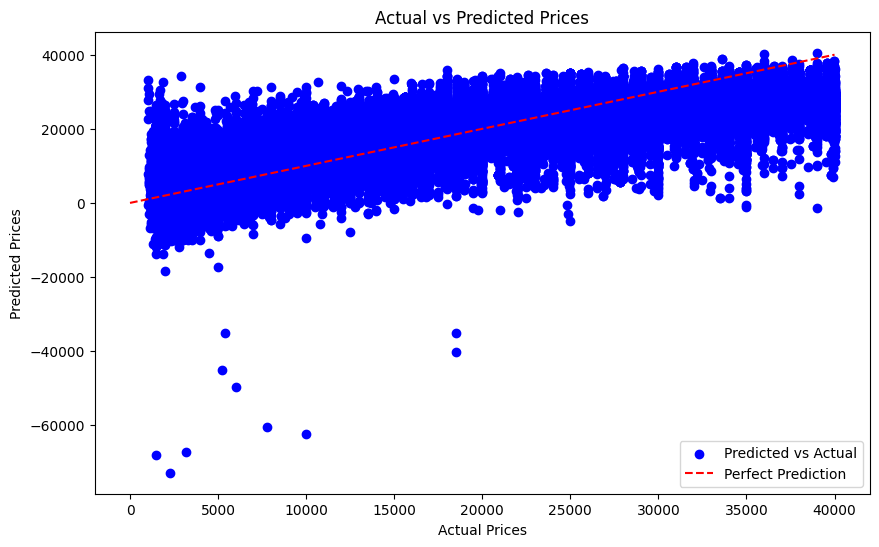

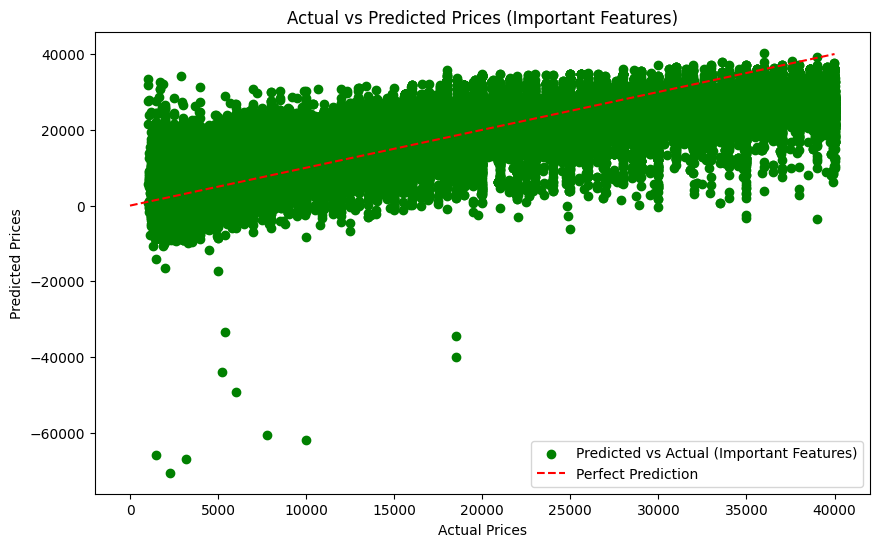

In [ ]:
# Plot Actual vs Predicted prices
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', label="Predicted vs Actual")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

# Plot Actual vs Predicted prices for the second model (Important Features)
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_important, color='green', label="Predicted vs Actual (Important Features)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.title('Actual vs Predicted Prices (Important Features)')
plt.legend()
plt.show()

